<a href="https://colab.research.google.com/github/kra268/ChemCoder/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyTDC rdkit==2023.03.1 DeepChem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from tdc.single_pred import ADME
data = ADME(name = 'Caco2_Wang')
data.get_data().head(2)

Found local copy...
Loading...
Done!


,Drug_ID,Drug,Y
0,(-)-epicatechin,Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(O)C2,-6.22
1,"(2E,4Z,8Z)-N-isobutyldodeca-2,4,10-triene-8 -y...",C/C=C\C#CCC/C=C\C=C\C(=O)NCC(C)C,-3.86


In [3]:
data

In [4]:
drugs = data.get_data()
drugs

,Drug_ID,Drug,Y
0,(-)-epicatechin,Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(O)C2,-6.220000
1,"(2E,4Z,8Z)-N-isobutyldodeca-2,4,10-triene-8 -y...",C/C=C\C#CCC/C=C\C=C\C(=O)NCC(C)C,-3.860000
2,codeine,COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2...,-4.090000
3,creatinine,CN1CC(=O)NC1=N,-5.935409
4,danazol,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=Cc5oncc5C[C@]4(...,-4.840000
...,...,...,...
905,Capric acid (decanoic acid),CCCCCCCCCC(=O)O,-4.680000
906,Apometzgerin (2),COc1cc(-c2cc(=O)c3c(O)cc(O)cc3o2)cc(O)c1OC,-4.950000
907,3,COC(=O)C[C@@H](C(=O)NN(Cc1ccc(/C=C\c2ccccc2)cc...,-5.080000
908,51d,COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=...,-5.300000


In [5]:
import rdkit
rdkit.__version__

'2023.03.1'

In [6]:
import pandas as pd
import numpy as np
from rdkit.Chem import PandasTools, Descriptors, AllChem, AddHs
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import seaborn as sns
import deepchem as dc

In [7]:
# Let's add the structures to the dataframe
PandasTools.AddMoleculeColumnToFrame(drugs, 'Drug', 'Molecule')

In [8]:
drugs.sample(5)

,Drug_ID,Drug,Y,Molecule
445,PB-27,Cn1cncc1CN1CC(N(Cc2ccccn2)S(=O)(=O)c2ccccn2)Cc...,-5.797940,<rdkit.Chem.rdchem.Mol object at 0x7f5b0ff3f990>
583,6b,CN(CCCN1CCC(CN2c3ccccc3Sc3ccc(C(=O)O)cc32)CC1)...,-5.720924,<rdkit.Chem.rdchem.Mol object at 0x7f5b0ff43680>
605,Cyclo(-PFMewKTMeF-) (7),C[C@@H](O)[C@@H]1NC(=O)[C@H](CCCCN)N(C)C(=O)[C...,-6.570000,<rdkit.Chem.rdchem.Mol object at 0x7f5b0ff4c040>
823,2,CCCCCCC(N)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N1CCC...,-5.450499,<rdkit.Chem.rdchem.Mol object at 0x7f5b0ff52030>
599,3,Cc1c(O)c2c(c(C)c1CCO[C@@H]1O[C@H](CO)[C@@H](O)...,-6.010721,<rdkit.Chem.rdchem.Mol object at 0x7f5b0ff43d10>


In [9]:
# There are no hydrogens in these structures. 
for idx, mol in enumerate(drugs.Molecule):
  drugs.Molecule[idx] = rdkit.Chem.AddHs(mol)

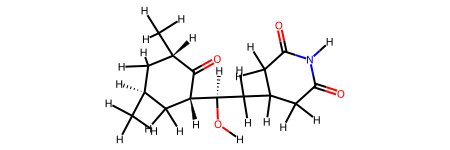

In [10]:
drugs.Molecule.iloc[-1]

In [11]:
# Lipinski's rule of 5:
# Poor absorption is likely if the molecule violates more than one of the following conditions:
# Molecular Weight <= 500 Da
# No. Hydrogen Bond Donors <= 10
# No. Hydrogen Bond Acceptors <= 5
# LogP <= 5

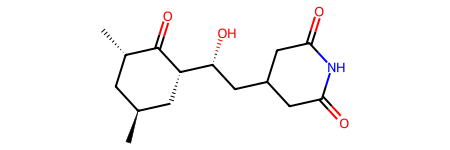

In [12]:
mol

In [13]:
# This chunk checks for Lipinski's rule of 5
MW = Descriptors.MolWt(mol)
HBA = Descriptors.NOCount(mol)
HBD = Descriptors.NHOHCount(mol)
LogP = Descriptors.MolLogP(mol)
conditions = [MW <= 500, HBA <= 10, HBD <= 5, LogP <= 5]
pass_ro5 = conditions.count(True) >= 3
print(pass_ro5)

True


In [14]:
def ro5_check(mol):
  MW = Descriptors.MolWt(mol)
  HBA = Descriptors.NOCount(mol)
  HBD = Descriptors.NHOHCount(mol)
  LogP = Descriptors.MolLogP(mol)
  conditions = [MW <= 500, HBA <= 10, HBD <= 5, LogP <= 5]
  pass_ro5 = conditions.count(True) >= 3
  return pass_ro5

In [15]:
# Let's make a new category to sort out all the drugs that violate the ro5
# If it follows ro5, the category = 1 else 0

In [16]:
drugs['ro5'] = 0
for idx, mol in enumerate(drugs.Molecule):
  if ro5_check(mol) == True:
    drugs.ro5[idx] = 1 

In [17]:
drugs.sample(20)

,Drug_ID,Drug,Y,Molecule,ro5
191,48,CC(C)(C)c1nn2ccccc2c1Cc1ccc(C(=O)N[C@@H]2CCOC[...,-5.366531,<rdkit.Chem.rdchem.Mol object at 0x7f5b0ff38970>,1
837,"(2E,4Z,8Z)-N-isobutyldodeca-2,4,10-triene-8 -y...",C/C=C/C#CCC/C=C\C=C\C(=O)NCC(C)C,-4.000000,<rdkit.Chem.rdchem.Mol object at 0x7f5b0ff525e0>,1
392,Cyclo(-PFwKTF-) (1),C[C@@H](O)[C@@H]1NC(=O)[C@H](CCCCN)NC(=O)[C@@H...,-6.220924,<rdkit.Chem.rdchem.Mol object at 0x7f5b0ff3e1f0>,0
663,6,CNC(=O)[C@@H](Cc1ccccc1)NC(=O)[C@@H](Cc1ccccc1...,-5.380000,<rdkit.Chem.rdchem.Mol object at 0x7f5b0ff4d930>,1
162,clozapine,CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1,-4.510000,<rdkit.Chem.rdchem.Mol object at 0x7f5b0ff33c30>,1
749,LEF553,N=C(N)NCCC[C@@H](NC(=O)[C@@H](N)Cc1ccc(O)cc1)C...,-7.760000,<rdkit.Chem.rdchem.Mol object at 0x7f5b0ff4fed0>,0
404,PNU-93936A,CC(=O)NCC1CN(c2cc(F)c(-c3ccncc3)c(F)c2)C(=O)O1,-4.290000,<rdkit.Chem.rdchem.Mol object at 0x7f5b0ff3e730>,1
843,ME3229,CCCCOC(=O)COc1ccc(C(=O)CNC(=O)c2cc3c(s2)CCNC3)...,-5.101186,<rdkit.Chem.rdchem.Mol object at 0x7f5b0ff52880>,1
112,oxprenolol ester,C=CCOc1ccccc1OC[C@@H](CNC(C)C)OC(=O)C1CC1,-4.545000,<rdkit.Chem.rdchem.Mol object at 0x7f5b0ff32650>,1
806,Proscillaridin,CC1OC(O[C@@H]2C=C3CC[C@@H]4[C@H](CC[C@]5(C)[C@...,-6.229985,<rdkit.Chem.rdchem.Mol object at 0x7f5b0ff51850>,1


In [18]:
# Let's look at the descriptors
des_keys = Descriptors.CalcMolDescriptors(drugs.Molecule[0]).keys()

In [19]:
des_keys

dict_keys(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10',

In [20]:
type(des_keys)

dict_keys

In [21]:
des = Descriptors.CalcMolDescriptors(drugs.Molecule[0])

In [22]:
len(des)

209

In [23]:
# Problem! It is difficult to calculate descriptors directly for the dataframe.
# Let's us use DeepChem

In [24]:
rdkit_featurizer = dc.feat.RDKitDescriptors()

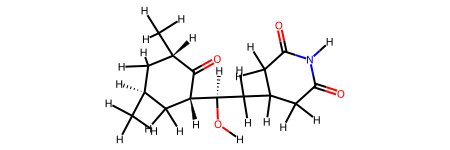

In [25]:
mol

In [26]:
rdkit_featurizer.featurize(mol)

array([[ 1.38516320e+01,  1.38516320e+01,  9.73220698e-01,
        -5.20893802e+00,  7.57155600e-01,  2.81352000e+02,
         2.58168000e+02,  2.81162708e+02,  1.12000000e+02,
         0.00000000e+00,  2.26338055e-01, -3.92368254e-01,
         3.92368254e-01,  2.26338055e-01,  1.55000000e+00,
         2.30000000e+00,  2.90000000e+00, -1.72683971e-16,
        -2.46769264e-01, -5.50314207e-17, -2.80808164e+00,
        -1.57050774e-16, -2.81461525e+00,  5.58036532e-18,
        -1.13431736e+00,  2.84389418e+00,  3.31501334e+00,
         1.21392725e+03,  3.50165079e+01,  3.25802068e+01,
         9.58020676e+00,  1.84414285e+01,  1.63691721e+01,
         5.01371018e+00,  3.50535682e+00,  3.50535682e+00,
         2.08667322e+00,  2.08667322e+00,  1.31143743e+00,
         1.31143743e+00, -1.23000000e+00,  2.84389418e+00,
         3.24011651e+00,  6.03773196e+00,  3.44974559e+00,
         1.51124489e+02,  5.10880819e+00,  5.78324495e+00,
         1.41184208e+00,  1.32455591e+01,  0.00000000e+0

In [27]:
type(rdkit_featurizer.featurize(mol))

numpy.ndarray

In [28]:
drugs['descriptors'] = drugs['Molecule'].apply(rdkit_featurizer.featurize)

In [29]:
drugs.sample(5)

,Drug_ID,Drug,Y,Molecule,ro5,descriptors
154,camptothecin,CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3ccccc3nc2-1,-4.110000,<rdkit.Chem.rdchem.Mol object at 0x7f5b0ff338b0>,1,"[[13.896591500797847, 13.896591500797847, 0.14..."
831,-,Oc1ccncc1,-4.108953,<rdkit.Chem.rdchem.Mol object at 0x7f5b0ff52340>,1,"[[7.134490740740741, 7.134490740740741, 0.4027..."
751,methanol,CO,-4.490000,<rdkit.Chem.rdchem.Mol object at 0x7f5b0ff50040>,1,"[[6.104166666666667, 6.104166666666667, 2.5416..."
130,sildenafil,CCCc1nn(C)c2c(=O)nc(-c3cc(S(=O)(=O)N4CCN(C)CC4...,-4.510000,<rdkit.Chem.rdchem.Mol object at 0x7f5b0ff32e30>,1,"[[14.620521919338605, 14.620521919338605, 0.31..."
389,H 95/71,CC(C)NCC(O)COc1ccc(NC=O)cc1,-5.427984,<rdkit.Chem.rdchem.Mol object at 0x7f5b0ff3e0a0>,1,"[[11.154602831335577, 11.154602831335577, 0.33..."


In [30]:
drugs.descriptors

0      [[8.856970427059712, 8.856970427059712, 0.8900...
1      [[12.563043391922376, 12.563043391922376, 1.03...
2      [[9.6092470946712, 9.6092470946712, 0.63608489...
3      [[11.160833333333333, 11.160833333333333, 0.03...
4      [[9.97418390967498, 9.97418390967498, 1.177787...
                             ...                        
905    [[11.447758335714909, 11.447758335714909, 2.34...
906    [[13.07531192803108, 13.07531192803108, 0.7630...
907    [[16.36939513581992, 16.36939513581992, 1.1186...
908    [[15.91044979799626, 15.91044979799626, 1.5069...
909    [[13.85163202317964, 13.85163202317964, 0.9732...
Name: descriptors, Length: 910, dtype: object

In [31]:
drugs.descriptors.isna().value_counts()

False    910
Name: descriptors, dtype: int64

In [32]:
# Separate the descriptors into columns
for idx, mol in enumerate(drugs.Molecule):
  all_des = Descriptors.CalcMolDescriptors(mol)
  for des in des_keys:
    drugs.loc[idx,des] = all_des[des]

drugs.sample(1)

,Drug_ID,Drug,Y,Molecule,ro5,descriptors,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
710,45a,COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=...,-4.89,<rdkit.Chem.rdchem.Mol object at 0x7f5b0ff4edc0>,0,"[[15.855542875082344, 15.855542875082344, 1.15...",15.855543,15.855543,1.159299,-6.956192,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
X = drugs
X.head(1)

,Drug_ID,Drug,Y,Molecule,ro5,descriptors,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,(-)-epicatechin,Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(O)C2,-6.22,<rdkit.Chem.rdchem.Mol object at 0x7f5b10643a70>,1,"[[8.856970427059712, 8.856970427059712, 0.8900...",8.85697,8.85697,0.890041,-3.607962,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
X = X.drop(columns=['Drug_ID','Drug','Molecule','descriptors'])
X.head(1)

,Y,ro5,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-6.22,1,8.85697,8.85697,0.890041,-3.607962,0.509593,290.271,276.159,290.079038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
X_fea = X.iloc[:,2:]

In [36]:
X_fea.head(1)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,8.85697,8.85697,0.890041,-3.607962,0.509593,290.271,276.159,290.079038,110.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
X['ro5']

0      1
1      1
2      1
3      1
4      1
      ..
905    1
906    1
907    0
908    0
909    1
Name: ro5, Length: 910, dtype: int64

In [38]:
y = X['Y']
y.head()

0   -6.220000
1   -3.860000
2   -4.090000
3   -5.935409
4   -4.840000
Name: Y, dtype: float64

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_fea, y,  
                                   random_state=414,
                                   shuffle=True,
                                   test_size=.2)
print(y_train.value_counts())
print(y_test.value_counts())

-5.820000    20
-5.300000    12
-4.510000     8
-5.700000     7
-5.000000     7
             ..
-4.449099     1
-5.090000     1
-7.390000     1
-5.935409     1
-5.597583     1
Name: Y, Length: 500, dtype: int64
-5.820000    6
-5.300000    5
-4.740000    3
-5.690000    2
-4.508638    2
            ..
-5.187451    1
-7.179571    1
-5.739719    1
-4.950000    1
-4.880000    1
Name: Y, Length: 157, dtype: int64


In [41]:
X_train.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
551,14.331780,14.331780,1.027819,-4.457490,0.275988,448.380,428.220,448.100561,170.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250,11.703233,11.703233,0.792811,-4.617064,0.703894,388.895,363.695,388.155370,144.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
492,15.059801,15.059801,0.273760,-6.540957,0.355867,534.590,508.382,534.146072,196.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
706,16.211838,16.211838,1.101428,-6.431418,0.111441,705.691,656.299,704.278462,254.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135,13.809505,13.809505,0.464390,-4.341167,0.830623,387.440,362.240,387.190654,150.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
X_test.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
848,15.658348,15.658348,0.191804,-5.676791,0.254614,589.806,546.462,589.308661,224.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
413,16.134254,16.134254,0.506755,-6.180133,0.732908,401.485,381.325,401.087926,142.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
370,12.890005,12.890005,0.749360,-4.335454,0.746755,306.406,280.198,306.194343,122.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180,16.257050,16.257050,1.187931,-6.111133,0.439507,501.864,481.704,501.107847,182.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
339,13.845410,13.845410,0.234264,-5.057938,0.772957,354.450,328.242,354.194343,138.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
y_train.head()

551   -6.100000
250   -5.500000
492   -5.851936
706   -5.320000
135   -4.610000
Name: Y, dtype: float64

In [44]:
y_test.head()

848   -5.959303
413   -5.888028
370   -4.590000
180   -4.552842
339   -4.810000
Name: Y, dtype: float64

In [45]:
len(X_train)

728

In [46]:
X_train[X_train.isnull().any(axis=1)]

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
91,13.151090,13.151090,0.0,-3.578285,0.366873,295.270,281.158,295.082052,104.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,11.559838,11.559838,0.0,-3.656906,0.638394,252.245,239.141,252.076239,88.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
X_train = X_train.drop(91)

KeyError: ignored

In [55]:
X_train = X_train.drop(102)

In [56]:
len(X_train)

726

In [57]:
for des in des_keys:
  print(X_train[des].isna().value_counts())

False    726
Name: MaxAbsEStateIndex, dtype: int64
False    726
Name: MaxEStateIndex, dtype: int64
False    726
Name: MinAbsEStateIndex, dtype: int64
False    726
Name: MinEStateIndex, dtype: int64
False    726
Name: qed, dtype: int64
False    726
Name: MolWt, dtype: int64
False    726
Name: HeavyAtomMolWt, dtype: int64
False    726
Name: ExactMolWt, dtype: int64
False    726
Name: NumValenceElectrons, dtype: int64
False    726
Name: NumRadicalElectrons, dtype: int64
False    726
Name: MaxPartialCharge, dtype: int64
False    726
Name: MinPartialCharge, dtype: int64
False    726
Name: MaxAbsPartialCharge, dtype: int64
False    726
Name: MinAbsPartialCharge, dtype: int64
False    726
Name: FpDensityMorgan1, dtype: int64
False    726
Name: FpDensityMorgan2, dtype: int64
False    726
Name: FpDensityMorgan3, dtype: int64
False    726
Name: BCUT2D_MWHI, dtype: int64
False    726
Name: BCUT2D_MWLOW, dtype: int64
False    726
Name: BCUT2D_CHGHI, dtype: int64
False    726
Name: BCUT2D_CHGLO, dt

In [58]:
# Let's do the same for y_train, X_test, and y_test

In [60]:
# y_train
#y_train = y_train.drop(91)
y_train = y_train.drop(102)
print(len(y_train))

726


In [61]:
# Now for the test set:
X_test[X_test.isnull().any(axis=1)]

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea


In [62]:
# Remove entry 102! 
#print(len(X_test))
#X_test = X_test.drop(102)
#y_test = y_test.drop(102)
print(len(y_test))

182


In [63]:
for des in des_keys:
  print(X_test[des].isna().value_counts())

False    182
Name: MaxAbsEStateIndex, dtype: int64
False    182
Name: MaxEStateIndex, dtype: int64
False    182
Name: MinAbsEStateIndex, dtype: int64
False    182
Name: MinEStateIndex, dtype: int64
False    182
Name: qed, dtype: int64
False    182
Name: MolWt, dtype: int64
False    182
Name: HeavyAtomMolWt, dtype: int64
False    182
Name: ExactMolWt, dtype: int64
False    182
Name: NumValenceElectrons, dtype: int64
False    182
Name: NumRadicalElectrons, dtype: int64
False    182
Name: MaxPartialCharge, dtype: int64
False    182
Name: MinPartialCharge, dtype: int64
False    182
Name: MaxAbsPartialCharge, dtype: int64
False    182
Name: MinAbsPartialCharge, dtype: int64
False    182
Name: FpDensityMorgan1, dtype: int64
False    182
Name: FpDensityMorgan2, dtype: int64
False    182
Name: FpDensityMorgan3, dtype: int64
False    182
Name: BCUT2D_MWHI, dtype: int64
False    182
Name: BCUT2D_MWLOW, dtype: int64
False    182
Name: BCUT2D_CHGHI, dtype: int64
False    182
Name: BCUT2D_CHGLO, dt

In [64]:
# Now there should be no NAN values in the DataFrame 

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [66]:
scaler = StandardScaler()

In [67]:
X_train = scaler.fit_transform(X_train)

In [68]:
X_test = scaler.transform(X_test)

In [69]:
lr = LinearRegression(copy_X=True,
                      fit_intercept=False)

In [70]:
des_keys

dict_keys(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10',

In [71]:
lr.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [72]:
lr_preds = lr.predict(X_test)

In [73]:
lr_preds

array([-0.04678339,  0.1192145 ,  0.88418073,  0.65991812, -0.16983062,
        0.32318086,  0.48349732,  0.11770982, -1.53300638,  0.40914755,
        0.82655209, -0.28322345,  1.04391317, -0.01041537, -0.13317613,
       -0.64755374,  0.59091061,  0.40601607,  0.63990659, -0.03452505,
        0.47058457,  0.32718496, -0.42754108, -0.05913001, -1.79409438,
        0.24613372, -0.15170032,  0.13515729, -0.23807651, -0.11919147,
       -0.59033328, -0.51935321,  0.0989787 , -0.0123685 ,  1.01272458,
       -0.30099136,  0.62733667,  0.73592156, -1.18218393, -0.37153605,
        0.50163858,  0.73944348, -0.16983062, -1.16705047,  0.31870028,
        1.28441781, -0.87993079,  0.74408978, -0.17341737, -1.03255585,
        0.25020379,  0.5017907 , -0.18905132, -1.76451902, -0.48817727,
       -1.61668998,  0.15957616,  0.62363213, -1.66490012,  0.62683992,
       -1.29865009,  0.68425244, -0.06679565, -0.45894404,  0.22772473,
       -0.16380435, -0.57960966, -0.04651423, -0.10416537, -0.81

In [74]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, lr_preds)

In [75]:
mse

27.848594548141712

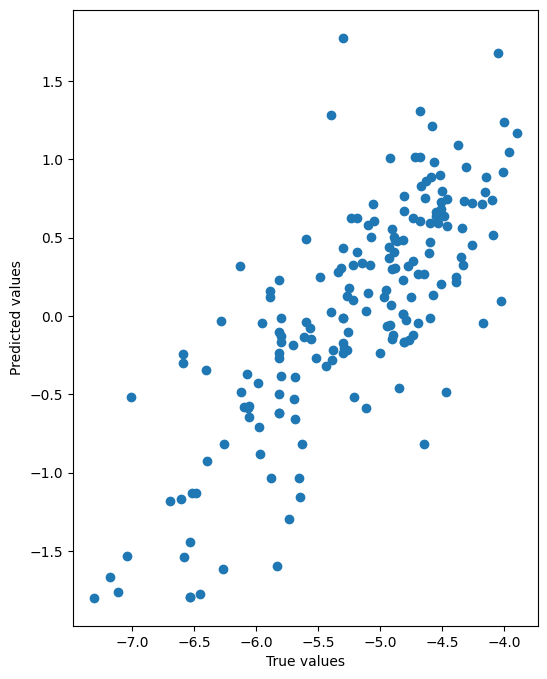

In [76]:
plt.figure(figsize=(6,8))
plt.scatter(y_test, lr_preds)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.show()